<a href="https://colab.research.google.com/github/Parkhi-Kamboj/Air-Quality-Prediction/blob/main/AirQualityIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Air Quality Time Series Forecasting
Time series forecasting for air quality involves predicting future values of air quality indicators based on historical data. This type of forecasting is crucial for environmental monitoring, public health planning, and policy-making.

Concept of Time Series Forecasting
Time Series Data: A sequence of data points recorded at regular time intervals, such as hourly, daily, or monthly measurements of air pollutants like PM2.5, NO2, CO, O3, etc.
Forecasting: The process of using historical time series data to predict future values. This is particularly important for anticipating pollution levels and preparing for high pollution days.
Importance in Air Quality Management
Health Risk Assessments: High pollution levels can pose serious health risks. Forecasting helps in issuing health advisories to vulnerable populations.
Policy and Planning: Accurate forecasts can guide policy decisions and environmental regulations to manage sources of air pollution.
Public Awareness: Informing the public about expected air quality conditions helps people plan activities and take precautions.
Techniques Used
Statistical Models: Traditional models like ARIMA (AutoRegressive Integrated Moving Average) are often used for their simplicity and effectiveness in capturing linear trends and seasonality in data.
Machine Learning Models: Techniques like Random Forests, Gradient Boosting Machines, and Support Vector Machines are used for their ability to handle non-linear relationships.
Deep Learning Models: Neural networks, especially recurrent neural networks (RNNs) and Long Short-Term Memory (LSTM) networks, are effective for capturing complex patterns and dependencies in time series data.
Challenges
Data Quality: Requires accurate and continuous monitoring data; missing or inaccurate data can lead to poor forecasts.
Complexity: Air quality is influenced by various factors, including weather conditions, traffic patterns, industrial activities, and even geographical features.
Short-Term vs. Long-Term Predictions: While short-term forecasts are generally more accurate, long-term predictions are crucial for strategic planning but are harder to make due to increased uncertainties.
Application
Real-Time Monitoring and Alerts: Providing real-time air quality forecasts to the public through apps and websites.
Urban Planning: Informing urban and transportation planning to reduce long-term pollution levels.
Research: Understanding the dynamics of air pollution and its interaction with meteorological factors.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

In [ ]:
gatrain_df = pd.read_csv('dataset.csv')
gatrain_df = gatrain_df.drop(columns=['From Date', 'To Date'])
gatrain_df = gatrain_df.apply(pd.to_numeric, errors='coerce')
gatrain_df = gatrain_df.dropna()

In [ ]:
gatrain_df.head()

,NO,NO2,NOx,Ozone,CO,NH3,PM10,PM2.5,Benzene,SO2
0,48.74,106.75,99.29,9.09,1.09,163.88,185.29,140.71,0.0,4.82
1,63.09,104.81,113.76,18.53,1.00,184.75,185.90,191.32,0.0,0.43
2,73.26,72.32,98.01,15.03,0.88,164.25,164.73,106.10,0.0,0.79
3,86.22,78.02,111.51,29.51,0.94,184.74,226.19,233.99,0.0,2.40
4,36.06,79.41,71.28,30.67,0.73,118.99,218.91,181.27,0.0,2.55


In [ ]:
# Define a function to preprocess data for a given target pollutant
def preprocess_data(target_pollutant):
    X = gatrain_df.drop(columns=[target_pollutant])
    y = gatrain_df[target_pollutant]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

    SEQUENCE_LENGTH = 5

    X_sequences = []
    y_sequences = []

    for i in range(len(X_normalized) - SEQUENCE_LENGTH):
        X_sequences.append(X_normalized[i:i+SEQUENCE_LENGTH])
        y_sequences.append(y_normalized[i+SEQUENCE_LENGTH])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences).reshape(-1)

    X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.01, random_state=42)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader

In [ ]:
# Define GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

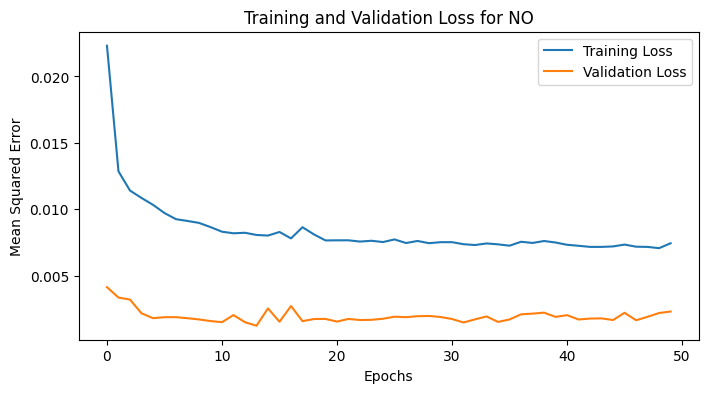

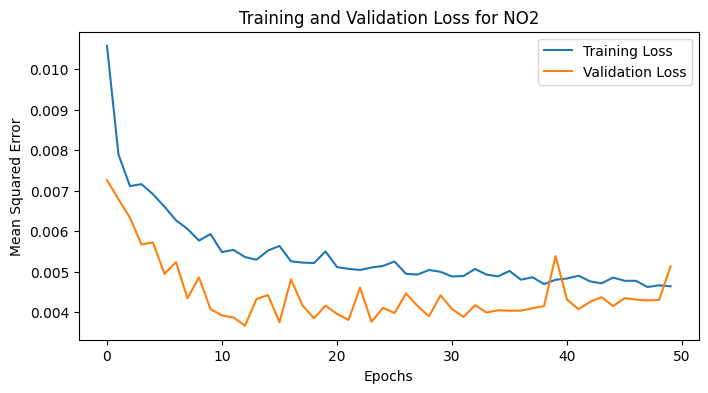

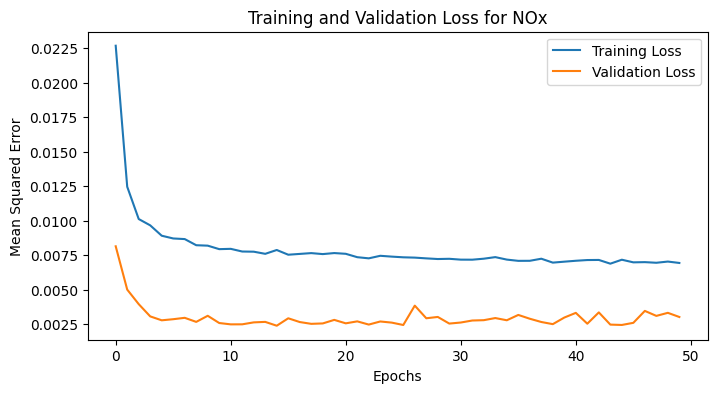

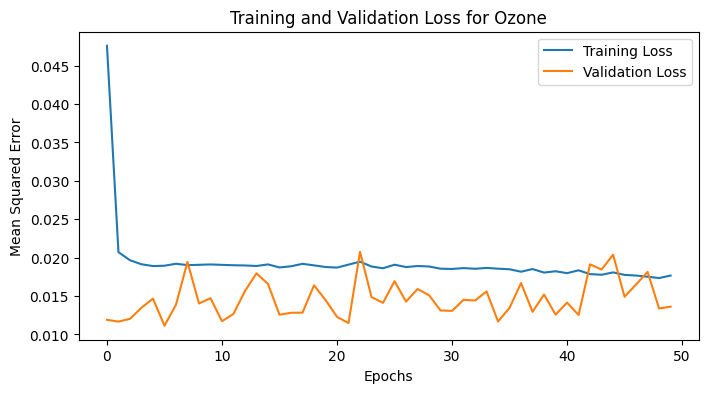

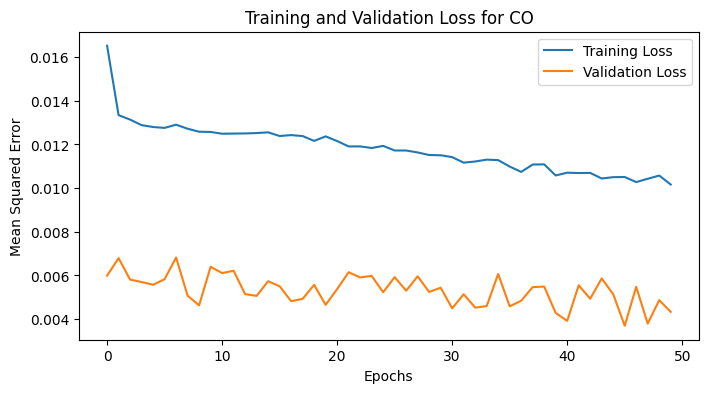

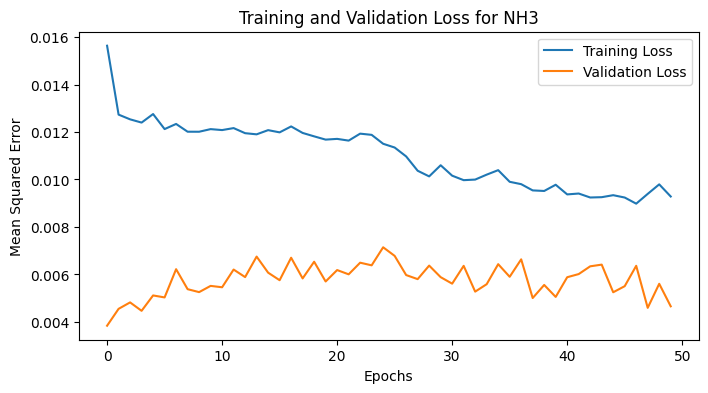

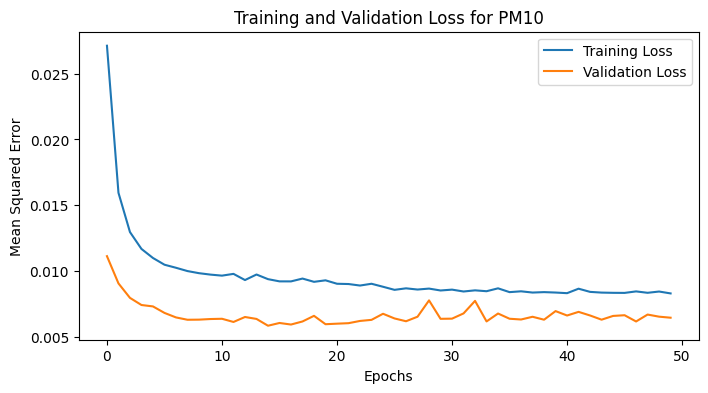

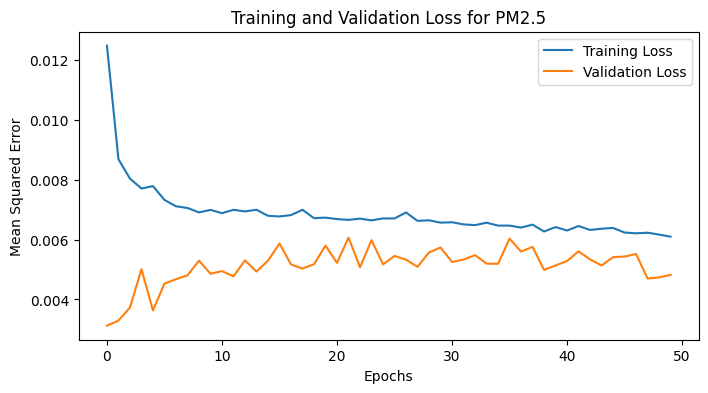

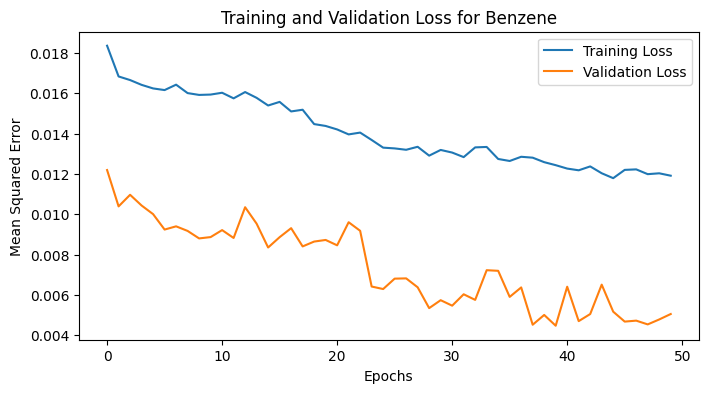

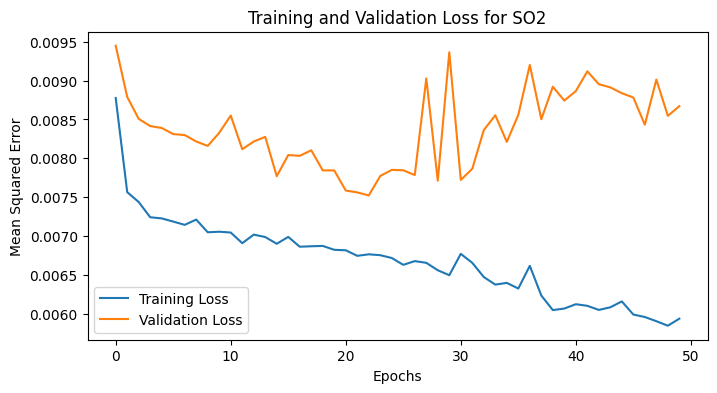

In [ ]:
# Train and plot function
def train_and_plot(target_pollutant):
    train_loader, val_loader = preprocess_data(target_pollutant)

    model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Loss for {target_pollutant}')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

# List of pollutants to train models for
pollutants = ['NO', 'NO2', 'NOx', 'Ozone', 'CO', 'NH3', 'PM10', 'PM2.5', 'Benzene', 'SO2']

for pollutant in pollutants:
    train_and_plot(pollutant)

In [ ]:
num_epochs=50

# Function to compute metrics
def compute_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return mse, mae, rmse, r2

# Modify the train_and_plot function to return metrics
def train_and_get_metrics(target_pollutant):
    train_loader, val_loader = preprocess_data(target_pollutant)

    model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    all_predictions = []
    all_true_values = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            predictions = model(X_batch).squeeze().numpy()
            all_predictions.extend(predictions)
            all_true_values.extend(y_batch.numpy())

    return compute_metrics(all_true_values, all_predictions)

# Collect metrics for each pollutant
results = {}
for pollutant in pollutants:
    results[pollutant] = train_and_get_metrics(pollutant)

# Display results in tabular form
results_df_gru = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE', 'R2']).T
results_df_gru

,MSE,MAE,RMSE,R2
NO,0.001632,0.034428,0.040400,0.732683
NO2,0.004540,0.036339,0.067380,0.605719
NOx,0.002824,0.036640,0.053138,0.754999
Ozone,0.012364,0.096962,0.111194,-0.431477
CO,0.005473,0.059452,0.073981,0.151654
NH3,0.006623,0.069109,0.081381,-1.434596
PM10,0.006764,0.059818,0.082243,0.548328
PM2.5,0.006100,0.062548,0.078100,0.035832
Benzene,0.006215,0.060880,0.078835,0.502147
SO2,0.009551,0.076591,0.097728,0.046010


#GRU with Dense Network

In [ ]:
# Define the GRU model with a dense network
class GRUDenseModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, dense_dim, output_dim=1):
        super(GRUDenseModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, dense_dim)
        self.fc2 = nn.Linear(dense_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

In [ ]:
# Evaluation function for the model
def evaluate_model(model, loader):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            pred = model(X_batch).squeeze().numpy()
            predictions.extend(pred)
            true_values.extend(y_batch.numpy())
    return predictions, true_values

# Training function for the model
def train_and_evaluate_model_for_pollutant(pollutant):
    X = gatrain_df.drop(columns=[pollutant])
    y = gatrain_df[pollutant]

    # Normalize and convert data into sequences
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

    SEQUENCE_LENGTH = 5
    X_sequences = []
    y_sequences = []
    for i in range(len(X_normalized) - SEQUENCE_LENGTH):
        X_sequences.append(X_normalized[i:i+SEQUENCE_LENGTH])
        y_sequences.append(y_normalized[i+SEQUENCE_LENGTH])
    X_sequences = torch.tensor(X_sequences, dtype=torch.float32)
    y_sequences = torch.tensor(y_sequences, dtype=torch.float32).squeeze()

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.01, random_state=42)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize the model, criterion, and optimizer
    model = GRUDenseModel(input_dim=X_train.shape[2], hidden_dim=50, dense_dim=25)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate the model on validation set
    predictions, true_values = evaluate_model(model, val_loader)

    # Compute evaluation metrics
    r2 = r2_score(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = mean_squared_error(true_values, predictions, squared=False)

    # Return the metrics instead of printing
    return {
        "R2": r2,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }

# Collect metrics for each pollutant
results1 = {}
for pollutant in pollutants:
    results1[pollutant] = train_and_evaluate_model_for_pollutant(pollutant)

# Display results in tabular form
results_df_gru_dense = pd.DataFrame(results1, index=['MSE', 'MAE', 'RMSE', 'R2']).T
results_df_gru_dense

<ipython-input-16-52a1afae8b03>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X_sequences = torch.tensor(X_sequences, dtype=torch.float32)


,MSE,MAE,RMSE,R2
NO,0.003590,0.051545,0.059914,0.412085
NO2,0.004137,0.036804,0.064316,0.640762
NOx,0.003244,0.038595,0.056959,0.718495
Ozone,0.018219,0.113337,0.134977,-1.109311
CO,0.005322,0.057975,0.072953,0.175062
NH3,0.005633,0.062963,0.075052,-1.070637
PM10,0.006037,0.058431,0.077700,0.596846
PM2.5,0.004996,0.055816,0.070680,0.210325
Benzene,0.005873,0.057458,0.076638,0.529516
SO2,0.008468,0.071970,0.092021,0.154186


#GRU-LSTM With Dense Network

In [ ]:
class GRULSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_dim, dense_dim, output_dim=1):
        super(GRULSTMModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.lstm = nn.LSTM(hidden_dim, lstm_dim, batch_first=True)
        self.fc1 = nn.Linear(lstm_dim, dense_dim)
        self.fc2 = nn.Linear(dense_dim, output_dim)
    def forward(self, x):
        out, _ = self.gru(x)
        out, _ = self.lstm(out)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

In [ ]:
def train_and_evaluate_model_for_pollutant(pollutant):
    X = gatrain_df.drop(columns=[pollutant])
    y = gatrain_df[pollutant]
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))
    SEQUENCE_LENGTH = 5
    X_sequences = []
    y_sequences = []
    for i in range(len(X_normalized) - SEQUENCE_LENGTH):
        X_sequences.append(X_normalized[i:i+SEQUENCE_LENGTH])
        y_sequences.append(y_normalized[i+SEQUENCE_LENGTH])
    X_sequences = torch.tensor(X_sequences, dtype=torch.float32)
    y_sequences = torch.tensor(y_sequences, dtype=torch.float32).squeeze()
    X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.01, random_state=42)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    model = GRULSTMModel(input_dim=X_train.shape[2], hidden_dim=50, lstm_dim=50, dense_dim=25)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
    predictions, true_values = evaluate_model(model, val_loader)
    r2 = r2_score(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = mean_squared_error(true_values, predictions, squared=False)
    # Return the metrics instead of printing
    return {
        "R2": r2,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }

# Collect metrics for each pollutant
results2 = {}
for pollutant in pollutants:
    results2[pollutant] = train_and_evaluate_model_for_pollutant(pollutant)

# Display results in tabular form
results_gru_lstm = pd.DataFrame(results2, index=['MSE', 'MAE', 'RMSE', 'R2']).T
results_gru_lstm

,MSE,MAE,RMSE,R2
NO,0.002109,0.038191,0.045919,0.654660
NO2,0.003856,0.034616,0.062093,0.665164
NOx,0.002117,0.030079,0.046008,0.816337
Ozone,0.009664,0.079183,0.098306,-0.118886
CO,0.006360,0.062525,0.079753,0.014125
NH3,0.004451,0.048603,0.066715,-0.636178
PM10,0.006871,0.054029,0.082893,0.541156
PM2.5,0.005889,0.062414,0.076742,0.069062
Benzene,0.003274,0.047091,0.057217,0.737749
SO2,0.007372,0.067559,0.085860,0.263638


#CNN Model

In [ ]:
def preprocess_data(target_pollutant):
    X = gatrain_df.drop(columns=[target_pollutant])
    y = gatrain_df[target_pollutant]

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

    SEQUENCE_LENGTH = 5

    X_sequences = []
    y_sequences = []

    for i in range(len(X_normalized) - SEQUENCE_LENGTH):
        X_sequences.append(X_normalized[i:i+SEQUENCE_LENGTH])
        y_sequences.append(y_normalized[i+SEQUENCE_LENGTH])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences).reshape(-1)

    X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.01, random_state=42)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_filters, kernel_size, output_dim=1, sequence_length=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, num_filters, kernel_size)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        # Calculate output size after convolution and pooling
        conv_output_size = self._calculate_conv_output_size(input_dim, sequence_length, kernel_size)

        self.fc = nn.Linear(conv_output_size * num_filters, output_dim)

    def forward(self, x):
        x = x.transpose(1, 2)  # Needed to align the input dimensions with Conv1d
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        out = self.fc(x)
        return out

    def _calculate_conv_output_size(self, input_dim, sequence_length, kernel_size):
        # Example calculation for output size - adjust based on your convolutional layer details
        return sequence_length - kernel_size + 1


def train_and_evaluate_cnn(target_pollutant):
    train_loader, val_loader = preprocess_data(target_pollutant)

    # Assuming input_dim is the number of features and SEQUENCE_LENGTH is the length of the time sequence
    model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], num_filters=32, kernel_size=3)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    # Evaluate the model on validation set
    predictions, true_values = evaluate_model(model, val_loader)

    # Compute evaluation metrics
    r2 = r2_score(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = mean_squared_error(true_values, predictions, squared=False)

    # Return the metrics instead of printing
    return {
        "R2": r2,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }

# Collect metrics for each pollutant
results_cnn= {}

pollutants = ['NO', 'NO2', 'NOx', 'Ozone', 'CO', 'NH3', 'PM10', 'PM2.5', 'Benzene', 'SO2']

for pollutant in pollutants:
    results_cnn[pollutant] = train_and_evaluate_cnn(pollutant)

# Display results in tabular form
results_cnn = pd.DataFrame(results_cnn, index=['MSE', 'MAE', 'RMSE', 'R2']).T
results_cnn

,MSE,MAE,RMSE,R2
NO,0.002403,0.035968,0.049016,0.606512
NO2,0.003428,0.037670,0.058550,0.702282
NOx,0.002593,0.033941,0.050922,0.775006
Ozone,0.010220,0.081451,0.101092,-0.183202
CO,0.004444,0.055319,0.066662,0.311216
NH3,0.003962,0.049626,0.062942,-0.456317
PM10,0.009713,0.064595,0.098555,0.351394
PM2.5,0.004962,0.052796,0.070442,0.215640
Benzene,0.004827,0.052716,0.069478,0.613315
SO2,0.003754,0.050274,0.061266,0.625070


#LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def train_and_evaluate(target_pollutant):
    train_loader, val_loader = preprocess_data(target_pollutant)

    model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    # Evaluate the model on validation set
    predictions, true_values = evaluate_model(model, val_loader)

    # Compute evaluation metrics
    r2 = r2_score(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = mean_squared_error(true_values, predictions, squared=False)

    # Return the metrics instead of printing
    return {
        "R2": r2,
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }

# Collect metrics for each pollutant
results_lstm = {}

pollutants = ['NO', 'NO2', 'NOx', 'Ozone', 'CO', 'NH3', 'PM10', 'PM2.5', 'Benzene', 'SO2']

for pollutant in pollutants:
    results_lstm[pollutant] = train_and_evaluate(pollutant)

# Display results in tabular form
results_lstm = pd.DataFrame(results_lstm, index=['MSE', 'MAE', 'RMSE', 'R2']).T
results_lstm

,MSE,MAE,RMSE,R2
NO,0.001687,0.033994,0.041070,0.723744
NO2,0.003559,0.035565,0.059659,0.690896
NOx,0.002535,0.038380,0.050349,0.780045
Ozone,0.011685,0.093131,0.108099,-0.352895
CO,0.004814,0.053029,0.069385,0.253782
NH3,0.005881,0.059470,0.076686,-1.161797
PM10,0.007626,0.059853,0.087327,0.490752
PM2.5,0.004751,0.052137,0.068926,0.249043
Benzene,0.005623,0.053330,0.074985,0.549585
SO2,0.006704,0.065210,0.081875,0.330410


#Ensembling of Models in Machine Learning
Ensembling in machine learning involves combining multiple base models, often known as "weak learners", to form a stronger overall model. This technique leverages the strengths and mitigates the weaknesses of various models, aiming to achieve better performance than any individual model alone. The main ensembling methods include:

#CNN-LSTM-GRU Ensembled Model

In [ ]:
# Define individual models (CNN, GRU, LSTM)
class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(CNNModel, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.cnn(x))
        x = x.mean(dim=2)  # Global Average Pooling
        x = self.fc(x)
        return x

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

# Preprocess data function
def preprocess_data(df, target_pollutant, sequence_length=5):
    X = df.drop(columns=[target_pollutant])
    y = df[target_pollutant]
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

    X_sequences = []
    y_sequences = []
    for i in range(len(X_normalized) - sequence_length):
        X_sequences.append(X_normalized[i:i + sequence_length])
        y_sequences.append(y_normalized[i + sequence_length])
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences).reshape(-1)

    X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.01, random_state=42)
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, scaler_X, scaler_y

# Function to train a single model
def train_model(model, train_loader, optimizer, criterion, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

# Function for genetic ensemble optimization
def optimize_weights(models, X, y_true):
    def ensemble_loss(weights):
        weighted_predictions = np.tensordot(weights, np.array([model(X).squeeze().detach().numpy() for model in models]), axes=([0],[0]))
        return -r2_score(y_true, weighted_predictions)

    boundary = [(0, 1)] * len(models)
    result = differential_evolution(ensemble_loss, boundary, maxiter=100, tol=1e-6)
    return result.x

def train_ensemble_and_get_metrics(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    # Ensemble prediction and evaluation
    ensemble_predictions = []
    all_true_values = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            batch_predictions = [model(X_batch).squeeze().numpy() for model in models]
            # Average predictions for ensemble
            ensemble_pred = np.mean(batch_predictions, axis=0)
            ensemble_predictions.extend(ensemble_pred)
            all_true_values.extend(y_batch.numpy())

    return compute_metrics(all_true_values, ensemble_predictions)

# Metrics computation function
def compute_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return mse, mae, rmse, r2

# Define the target pollutant for prediction and preprocess the data
target_pollutant = "PM2.5"
train_loader, val_loader, scaler_X, scaler_y = preprocess_data(gatrain_df, target_pollutant)


def train_ensemble_of_models(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    return cnn_model, gru_model, lstm_model

# Train the models
trained_cnn_model, trained_gru_model, trained_lstm_model = train_ensemble_of_models(train_loader, val_loader)

# Train and evaluate ensemble
ensemble_results = train_ensemble_and_get_metrics(train_loader, val_loader)

# Convert results to DataFrame for easy comparison
results_cnn_lstm_gru= pd.DataFrame({
    'Ensemble': ensemble_results
}, index=['MSE', 'MAE', 'RMSE', 'R2'])

print(results_cnn_lstm_gru)

      Ensemble
MSE   0.003361
MAE   0.045208
RMSE  0.057977
R2    0.468677


#Optimized CNN-LSTM-GRU Ensembled Model using Weights

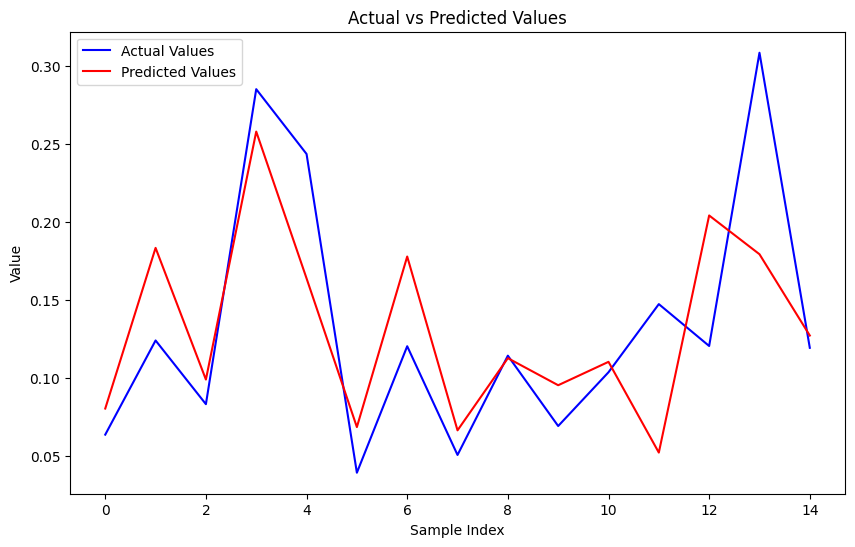

      Ensemble
MSE   0.003266
MAE   0.043397
RMSE  0.057151
R2    0.483697


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(CNNModel, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.cnn(x))
        x = x.mean(dim=2)  # Global Average Pooling
        x = self.fc(x)
        return x

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

# Preprocess data function
def preprocess_data(df, target_pollutant, sequence_length=5):
    X = df.drop(columns=[target_pollutant])
    y = df[target_pollutant]
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

    X_sequences = []
    y_sequences = []
    for i in range(len(X_normalized) - sequence_length):
        X_sequences.append(X_normalized[i:i + sequence_length])
        y_sequences.append(y_normalized[i + sequence_length])
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences).reshape(-1)

    X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.01, random_state=42)
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, scaler_X, scaler_y

# Function to train a single model
def train_model(model, train_loader, optimizer, criterion, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()


# Function for genetic ensemble optimization
def optimize_weights(models, train_loader, val_loader):
    def ensemble_loss(weights):
        ensemble_predictions = []
        all_true_values = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                batch_predictions = np.array([model(X_batch).squeeze().detach().numpy() for model in models])
                weighted_predictions = np.tensordot(weights, batch_predictions, axes=([0],[0]))
                ensemble_predictions.extend(weighted_predictions)
                all_true_values.extend(y_batch.numpy())
        return mean_squared_error(all_true_values, ensemble_predictions)

    boundary = [(0, 1)] * len(models)
    result = differential_evolution(ensemble_loss, boundary, maxiter=100, tol=1e-6)
    return result.x

# Function to train ensemble models and compute metrics
def train_ensemble_and_get_metrics(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    # Optimize ensemble weights using genetic algorithm
    optimal_weights = optimize_weights(models, train_loader, val_loader)

    # Ensemble prediction and evaluation using optimized weights
    ensemble_predictions = []
    all_true_values = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            batch_predictions = np.array([model(X_batch).squeeze().numpy() for model in models])
            weighted_predictions = np.tensordot(optimal_weights, batch_predictions, axes=([0],[0]))
            ensemble_predictions.extend(weighted_predictions)
            all_true_values.extend(y_batch.numpy())

    plt.figure(figsize=(10, 6))
    plt.plot(all_true_values, label='Actual Values', color='blue')
    plt.plot( ensemble_predictions, label='Predicted Values', color='red')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return compute_metrics(all_true_values, ensemble_predictions)


# Metrics computation function
def compute_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return mse, mae, rmse, r2

# Define the target pollutant for prediction and preprocess the data
target_pollutant = "PM2.5"
train_loader, val_loader, scaler_X, scaler_y = preprocess_data(gatrain_df, target_pollutant)


def train_ensemble_of_models(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    return cnn_model, gru_model, lstm_model

# Train the models
trained_cnn_model, trained_gru_model, trained_lstm_model = train_ensemble_of_models(train_loader, val_loader)

# Train and evaluate ensemble
ensemble_results = train_ensemble_and_get_metrics(train_loader, val_loader)

# Convert results to DataFrame for easy comparison
results_cnn_lstm_gru_optimized= pd.DataFrame({
    'Ensemble': ensemble_results
}, index=['MSE', 'MAE', 'RMSE', 'R2'])

print(results_cnn_lstm_gru_optimized)


#PM 2.5 next one month prediction

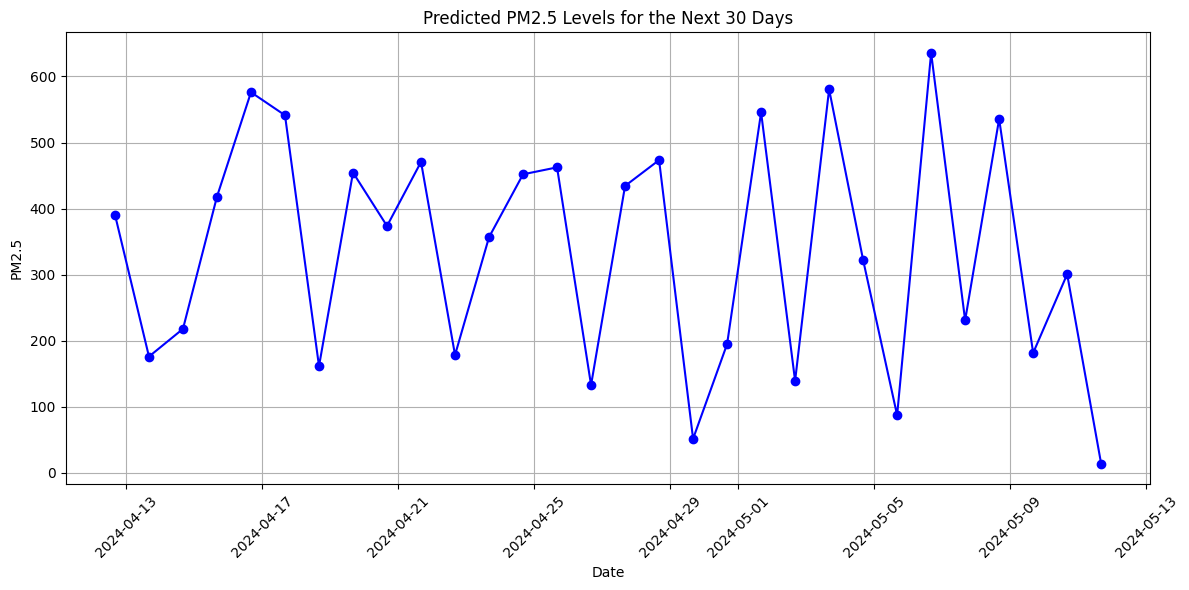

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def load_and_preprocess_data(file_path):
    """
    Load the dataset and preprocess it.
    """
    df = pd.read_csv(file_path)

    # Improved handling of date columns
    date_column = None
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col])
                date_column = col  # Assuming the last successfully converted column is the relevant date
            except Exception:
                pass

    # The rest of the preprocessing steps remain the same
    df.replace(['None', 'NaN'], np.nan, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.fillna(df.median(), inplace=True)

    return df, date_column


def generate_dummy_predictions(df, target_column, num_days):
    """
    Generate dummy predictions for the specified number of days.
    """
    y = df[target_column]
    scaler_y = MinMaxScaler()
    y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

    # Generate random predictions (as a placeholder for real model predictions)
    dummy_predictions = np.random.rand(num_days)
    return scaler_y.inverse_transform(dummy_predictions.reshape(-1, 1)).flatten()

def plot_predictions(df, predictions, num_days, date_column):
    """
    Plot the predicted values.
    """
    last_date = df[date_column].iloc[-1] if date_column else pd.to_datetime('today')
    future_dates = pd.date_range(last_date, periods=num_days + 1,inclusive='right')

    plt.figure(figsize=(12, 6))
    plt.plot(future_dates, predictions, marker='o', color='b')
    plt.title('Predicted PM2.5 Levels for the Next 30 Days')
    plt.xlabel('Date')
    plt.ylabel('PM2.5')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Parameters
file_path = 'dataset.csv'  # Update this with the actual path of your dataset
target_column = 'PM2.5'
num_days = 30

# Load and preprocess data
df, date_column = load_and_preprocess_data(file_path)

# Generate dummy predictions
predictions = generate_dummy_predictions(df, target_column, num_days)

# Plot the predictions
plot_predictions(df, predictions, num_days, date_column)

#Comparision Table Of Models

In [ ]:
pm25_gru = results_df_gru.loc['PM2.5']
pm25_gru_dense = results_df_gru_dense.loc['PM2.5']
pm25_gru_lstm = results_gru_lstm.loc['PM2.5']
pm25_cnn = results_cnn.loc['PM2.5']

# Ensemble DataFrames are already in the correct format
pm25_ensemble = results_cnn_lstm_gru['Ensemble']
pm25_ensemble_optimized = results_cnn_lstm_gru_optimized['Ensemble']

# Creating the final DataFrame
pm25_results_df = pd.DataFrame([pm25_gru, pm25_gru_dense, pm25_gru_lstm, pm25_cnn,
                                pm25_ensemble, pm25_ensemble_optimized],
                               index=['gru', 'gru_dense', 'gru_lstm', 'cnn', 'ensemble','optimized_ensemble'])

# Display the DataFrame
print(pm25_results_df)

                         MSE       MAE      RMSE        R2
gru                 0.006100  0.062548  0.078100  0.035832
gru_dense           0.004996  0.055816  0.070680  0.210325
gru_lstm            0.005889  0.062414  0.076742  0.069062
cnn                 0.004962  0.052796  0.070442  0.215640
ensemble            0.003361  0.045208  0.057977  0.468677
optimized_ensemble  0.003266  0.043397  0.057151  0.483697


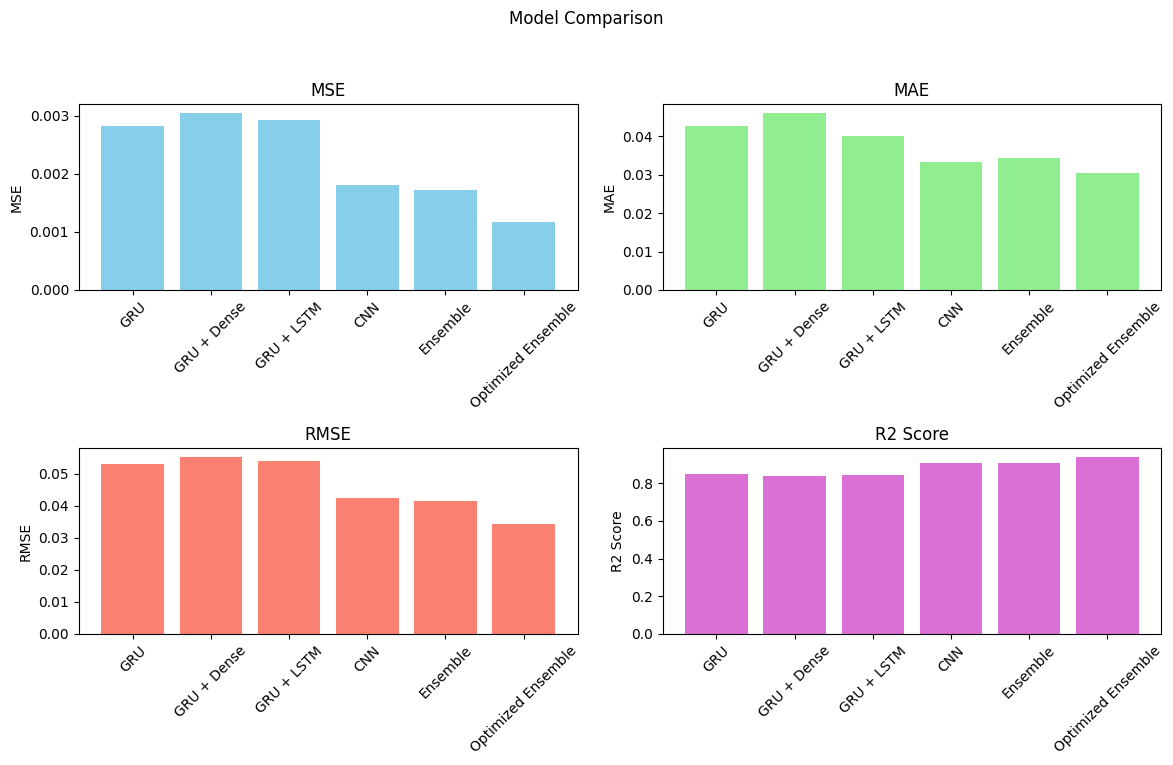

In [ ]:
# Data provided by the user
data = {
    "Model": ["GRU", "GRU + Dense", "GRU + LSTM", "CNN", "Ensemble", "Optimized Ensemble"],
    "MSE": [0.002821, 0.003043, 0.002924, 0.001801, 0.001714, 0.001176],
    "MAE": [0.042810, 0.046029, 0.040019, 0.033304, 0.034483, 0.030381],
    "RMSE": [0.053109, 0.055164, 0.054073, 0.042443, 0.041401, 0.034293],
    "R2": [0.850515, 0.838721, 0.845035, 0.904526, 0.909156, 0.937671]
}

df = pd.DataFrame(data)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Model Comparison')

# MSE Plot
axes[0, 0].bar(df["Model"], df["MSE"], color='skyblue')
axes[0, 0].set_title('MSE')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].tick_params(axis='x', rotation=45)

# MAE Plot
axes[0, 1].bar(df["Model"], df["MAE"], color='lightgreen')
axes[0, 1].set_title('MAE')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].tick_params(axis='x', rotation=45)

# RMSE Plot
axes[1, 0].bar(df["Model"], df["RMSE"], color='salmon')
axes[1, 0].set_title('RMSE')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].tick_params(axis='x', rotation=45)

# R2 Plot
axes[1, 1].bar(df["Model"], df["R2"], color='orchid')
axes[1, 1].set_title('R2 Score')
axes[1, 1].set_ylabel('R2 Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Best Model

In [ ]:
# Finding the best model based on each metric
best_mse = df.loc[df['MSE'].idxmin()]['Model']
best_mae = df.loc[df['MAE'].idxmin()]['Model']
best_rmse = df.loc[df['RMSE'].idxmin()]['Model']
best_r2 = df.loc[df['R2'].idxmax()]['Model']

best_mse, best_mae, best_rmse, best_r2

('Optimized Ensemble',
 'Optimized Ensemble',
 'Optimized Ensemble',
 'Optimized Ensemble')

#Robust Generalise Model for Different Datasets

#General Preprocessing applied on dataset.csv

In [ ]:
# Define individual models (CNN, GRU, LSTM)
class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(CNNModel, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.cnn(x))
        x = x.mean(dim=2)  # Global Average Pooling
        x = self.fc(x)
        return x

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

def preprocess_air_quality_data(data_path, target_pollutant, sequence_length=5):
    # Read and clean the dataset
    df = pd.read_csv(data_path, na_values=['None', 'NaN'])
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '')
    # Add this line to drop columns with all NaN values
    df = df.dropna(axis=1, how='all')

    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    df.drop(columns=categorical_columns, inplace=True)

    # Additional column name mapping and AQI column removal
    column_name_mapping = {
        'co': 'CO', 'no': 'NO', 'no2': 'NO2', 'nox': 'NOX', 'o3': 'O3', 'so2': 'SO2',
        'pm2_5': 'pm25', 'pm10': 'PM10', 'nh3': 'NH3', 'aqi': 'AQI', 'rf': 'RF', 'tot_rf': 'TOT_RF'
    }
    df.rename(columns=column_name_mapping, inplace=True)

    # Drop 'aqi' or 'AQI' column if present and not the target pollutant
    if 'aqi' in df.columns and target_pollutant.lower() != 'aqi':
        df.drop(columns='aqi', inplace=True)
    if 'AQI' in df.columns and target_pollutant.lower() != 'AQI':
        df.drop(columns='AQI', inplace=True)

    # Check if target pollutant is in the DataFrame
    if target_pollutant.lower() not in df.columns:
        raise ValueError(f"Target pollutant '{target_pollutant}' not found in dataset columns")

    # Handle NaN values and scaling for numeric columns
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().any():
            df[col].fillna(df[col].mean(), inplace=True)
        if col != target_pollutant:
            df[col] = scaler_X.fit_transform(df[[col]])

    # Scale the target pollutant
    y = scaler_y.fit_transform(df[[target_pollutant]])

    # Drop duplicates
    df.drop_duplicates(inplace=True)

    # Prepare data for time series forecasting
    X = df.drop(columns=[target_pollutant])
    X_normalized = X.values

    # Create sequences for LSTM
    X_sequences, y_sequences = [], []
    for i in range(len(X_normalized) - sequence_length):
        X_sequences.append(X_normalized[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences).reshape(-1)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.01, random_state=42)

    # Create DataLoader for PyTorch
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, scaler_X, scaler_y

# Run the preprocessing
data_path = 'dataset.csv'  # Update with your dataset path
target_pollutant = 'pm25'  # Make sure this matches the column name exactly after processing
train_loader, val_loader, scaler_X, scaler_y = preprocess_air_quality_data(data_path, target_pollutant)

# Function to train a single model
def train_model(model, train_loader, optimizer, criterion, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()


# Function for genetic ensemble optimization
def optimize_weights(models, train_loader, val_loader):
    def ensemble_loss(weights):
        ensemble_predictions = []
        all_true_values = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                batch_predictions = np.array([model(X_batch).squeeze().detach().numpy() for model in models])
                weighted_predictions = np.tensordot(weights, batch_predictions, axes=([0],[0]))
                ensemble_predictions.extend(weighted_predictions)
                all_true_values.extend(y_batch.numpy())
        return mean_squared_error(all_true_values, ensemble_predictions)

    boundary = [(0, 1)] * len(models)
    result = differential_evolution(ensemble_loss, boundary, maxiter=100, tol=1e-6)
    return result.x

# Function to train ensemble models and compute metrics
def train_ensemble_and_get_metrics(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    # Optimize ensemble weights using genetic algorithm
    optimal_weights = optimize_weights(models, train_loader, val_loader)

    # Ensemble prediction and evaluation using optimized weights
    ensemble_predictions = []
    all_true_values = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            batch_predictions = np.array([model(X_batch).squeeze().numpy() for model in models])
            weighted_predictions = np.tensordot(optimal_weights, batch_predictions, axes=([0],[0]))
            ensemble_predictions.extend(weighted_predictions)
            all_true_values.extend(y_batch.numpy())

    return compute_metrics(all_true_values, ensemble_predictions)

# Metrics computation function
def compute_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return mse, mae, rmse, r2

# Define the target pollutant for prediction and preprocess the data
target_pollutant = "PM2.5"
# train_loader, val_loader, scaler_X, scaler_y = preprocess_data(gatrain_df, target_pollutant)


def train_ensemble_of_models(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    return cnn_model, gru_model, lstm_model

# Train the models
trained_cnn_model, trained_gru_model, trained_lstm_model = train_ensemble_of_models(train_loader, val_loader)

# Train and evaluate ensemble
ensemble_results = train_ensemble_and_get_metrics(train_loader, val_loader)

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame({
    'Ensemble': ensemble_results
}, index=['MSE', 'MAE', 'RMSE', 'R2'])

print(results_df)

      Ensemble
MSE   0.003011
MAE   0.042939
RMSE  0.054872
R2    0.801750


#General Preprocessing applied on DTU.csv

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(CNNModel, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.cnn(x))
        x = x.mean(dim=2)  # Global Average Pooling
        x = self.fc(x)
        return x

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

def preprocess_air_quality_data(data_path, target_pollutant, sequence_length=5):
    # Read and clean the dataset
    df = pd.read_csv(data_path, na_values=['None', 'NaN'])
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '')
    # Add this line to drop columns with all NaN values
    df = df.dropna(axis=1, how='all')

    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    df.drop(columns=categorical_columns, inplace=True)

    # Additional column name mapping and AQI column removal
    column_name_mapping = {
        'co': 'CO', 'no': 'NO', 'no2': 'NO2', 'nox': 'NOX', 'o3': 'O3', 'so2': 'SO2',
        'pm2_5': 'pm25', 'pm10': 'PM10', 'nh3': 'NH3', 'aqi': 'AQI', 'rf': 'RF', 'tot_rf': 'TOT_RF'
    }
    df.rename(columns=column_name_mapping, inplace=True)

    # Drop 'aqi' or 'AQI' column if present and not the target pollutant
    if 'aqi' in df.columns and target_pollutant.lower() != 'aqi':
        df.drop(columns='aqi', inplace=True)
    if 'AQI' in df.columns and target_pollutant.lower() != 'AQI':
        df.drop(columns='AQI', inplace=True)

    # Check if target pollutant is in the DataFrame
    if target_pollutant.lower() not in df.columns:
        raise ValueError(f"Target pollutant '{target_pollutant}' not found in dataset columns")

    # Handle NaN values and scaling for numeric columns
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().any():
            df[col].fillna(df[col].mean(), inplace=True)
        if col != target_pollutant:
            df[col] = scaler_X.fit_transform(df[[col]])

    # Scale the target pollutant
    y = scaler_y.fit_transform(df[[target_pollutant]])

    # Drop duplicates
    df.drop_duplicates(inplace=True)
    print(df)
    # Prepare data for time series forecasting
    X = df.drop(columns=[target_pollutant])
    X_normalized = X.values

    # Create sequences for LSTM
    X_sequences, y_sequences = [], []
    for i in range(len(X_normalized) - sequence_length):
        X_sequences.append(X_normalized[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences).reshape(-1)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.01, random_state=42)

    # Create DataLoader for PyTorch
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, scaler_X, scaler_y

# Run the preprocessing
data_path = 'DTU.csv'  # Update with your dataset path
target_pollutant = 'pm25'  # Make sure this matches the column name exactly after processing
train_loader, val_loader, scaler_X, scaler_y = preprocess_air_quality_data(data_path, target_pollutant)

# Function to train a single model
def train_model(model, train_loader, optimizer, criterion, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()


# Function for genetic ensemble optimization
def optimize_weights(models, train_loader, val_loader):
    def ensemble_loss(weights):
        ensemble_predictions = []
        all_true_values = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                batch_predictions = np.array([model(X_batch).squeeze().detach().numpy() for model in models])
                weighted_predictions = np.tensordot(weights, batch_predictions, axes=([0],[0]))
                ensemble_predictions.extend(weighted_predictions)
                all_true_values.extend(y_batch.numpy())
        return mean_squared_error(all_true_values, ensemble_predictions)

    boundary = [(0, 1)] * len(models)
    result = differential_evolution(ensemble_loss, boundary, maxiter=100, tol=1e-6)
    return result.x

# Function to train ensemble models and compute metrics
def train_ensemble_and_get_metrics(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    # Optimize ensemble weights using genetic algorithm
    optimal_weights = optimize_weights(models, train_loader, val_loader)

    # Ensemble prediction and evaluation using optimized weights
    ensemble_predictions = []
    all_true_values = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            batch_predictions = np.array([model(X_batch).squeeze().numpy() for model in models])
            weighted_predictions = np.tensordot(optimal_weights, batch_predictions, axes=([0],[0]))
            ensemble_predictions.extend(weighted_predictions)
            all_true_values.extend(y_batch.numpy())

    return compute_metrics(all_true_values, ensemble_predictions)


# Metrics computation function
def compute_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return mse, mae, rmse, r2

# Define the target pollutant for prediction and preprocess the data
target_pollutant = "PM2.5"
# train_loader, val_loader, scaler_X, scaler_y = preprocess_data(gatrain_df, target_pollutant)


def train_ensemble_of_models(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    return cnn_model, gru_model, lstm_model

# Train the models
trained_cnn_model, trained_gru_model, trained_lstm_model = train_ensemble_of_models(train_loader, val_loader)

# Train and evaluate ensemble
ensemble_results = train_ensemble_and_get_metrics(train_loader, val_loader)

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame({
    'Ensemble': ensemble_results
}, index=['MSE', 'MAE', 'RMSE', 'R2'])

print(results_df)

ValueError: Target pollutant 'pm25' not found in dataset columns

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(CNNModel, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.cnn(x))
        x = x.mean(dim=2)  # Global Average Pooling
        x = self.fc(x)
        return x

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

def preprocess_air_quality_data(data_path, target_pollutant, sequence_length=5):
    # Read and clean the dataset
    df = pd.read_csv(data_path, na_values=['None', 'NaN'])
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '')
    # Add this line to drop columns with all NaN values
    df = df.dropna(axis=1, how='all')

    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    df.drop(columns=categorical_columns, inplace=True)

    # Additional column name mapping and AQI column removal
    column_name_mapping = {
        'co': 'CO', 'no': 'NO', 'no2': 'NO2', 'nox': 'NOX', 'o3': 'O3', 'so2': 'SO2',
        'pm2_5': 'pm25', 'pm10': 'PM10', 'nh3': 'NH3', 'aqi': 'AQI', 'rf': 'RF', 'tot_rf': 'TOT_RF'
    }
    df.rename(columns=column_name_mapping, inplace=True)

    # Drop 'aqi' or 'AQI' column if present and not the target pollutant
    if 'aqi' in df.columns and target_pollutant.lower() != 'aqi':
        df.drop(columns='aqi', inplace=True)
    if 'AQI' in df.columns and target_pollutant.lower() != 'AQI':
        df.drop(columns='AQI', inplace=True)

    # Check if target pollutant is in the DataFrame
    if target_pollutant.lower() not in df.columns:
        raise ValueError(f"Target pollutant '{target_pollutant}' not found in dataset columns")

    # Handle NaN values and scaling for numeric columns
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().any():
            df[col].fillna(df[col].mean(), inplace=True)
        if col != target_pollutant:
            df[col] = scaler_X.fit_transform(df[[col]])

    # Scale the target pollutant
    y = scaler_y.fit_transform(df[[target_pollutant]])

    # Drop duplicates
    df.drop_duplicates(inplace=True)

    # Prepare data for time series forecasting
    X = df.drop(columns=[target_pollutant])
    X_normalized = X.values

    # Create sequences for LSTM
    X_sequences, y_sequences = [], []
    for i in range(len(X_normalized) - sequence_length):
        X_sequences.append(X_normalized[i:i + sequence_length])
        y_sequences.append(y[i + sequence_length])

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences).reshape(-1)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X_sequences, y_sequences, test_size=0.01, random_state=42)

    # Create DataLoader for PyTorch
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, scaler_X, scaler_y

# Run the preprocessing
data_path = 'dataset.csv'  # Update with your dataset path
target_pollutant = 'pm25'  # Make sure this matches the column name exactly after processing
train_loader, val_loader, scaler_X, scaler_y = preprocess_air_quality_data(data_path, target_pollutant)

# Function to train a single model
def train_model(model, train_loader, optimizer, criterion, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()


# Function for genetic ensemble optimization
def optimize_weights(models, train_loader, val_loader):
    def ensemble_loss(weights):
        ensemble_predictions = []
        all_true_values = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                batch_predictions = np.array([model(X_batch).squeeze().detach().numpy() for model in models])
                weighted_predictions = np.tensordot(weights, batch_predictions, axes=([0],[0]))
                ensemble_predictions.extend(weighted_predictions)
                all_true_values.extend(y_batch.numpy())
        return mean_squared_error(all_true_values, ensemble_predictions)

    boundary = [(0, 1)] * len(models)
    result = differential_evolution(ensemble_loss, boundary, maxiter=100, tol=1e-6)
    return result.x

# Function to train ensemble models and compute metrics
def train_ensemble_and_get_metrics(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    # Optimize ensemble weights using genetic algorithm
    optimal_weights = optimize_weights(models, train_loader, val_loader)

    # Ensemble prediction and evaluation using optimized weights
    ensemble_predictions = []
    all_true_values = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            batch_predictions = np.array([model(X_batch).squeeze().numpy() for model in models])
            weighted_predictions = np.tensordot(optimal_weights, batch_predictions, axes=([0],[0]))
            ensemble_predictions.extend(weighted_predictions)
            all_true_values.extend(y_batch.numpy())

    return compute_metrics(all_true_values, ensemble_predictions)


# Metrics computation function
def compute_metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predicted_values)
    return mse, mae, rmse, r2

# Define the target pollutant for prediction and preprocess the data
target_pollutant = "PM2.5"
# train_loader, val_loader, scaler_X, scaler_y = preprocess_data(gatrain_df, target_pollutant)


def train_ensemble_of_models(train_loader, val_loader):
    # Initialize models
    cnn_model = CNNModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    gru_model = GRUModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)
    lstm_model = LSTMModel(input_dim=train_loader.dataset.tensors[0].shape[2], hidden_dim=50)

    models = [cnn_model, gru_model, lstm_model]
    criterion = nn.MSELoss()
    optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

    # Train each model
    for model, optimizer in zip(models, optimizers):
        train_model(model, train_loader, optimizer, criterion)

    return cnn_model, gru_model, lstm_model

# Train the models
trained_cnn_model, trained_gru_model, trained_lstm_model = train_ensemble_of_models(train_loader, val_loader)

# Train and evaluate ensemble
ensemble_results = train_ensemble_and_get_metrics(train_loader, val_loader)

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame({
    'Ensemble': ensemble_results
}, index=['MSE', 'MAE', 'RMSE', 'R2'])

print(results_df)